## **IMPORTING REQUIRED MODULES**

In [1]:
!pip install segmentation_models 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys, os.path
import glob
import matplotlib
import pickle
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import cv2
import skimage.io as io
from skimage.transform import rotate
import keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.layers.normalization import BatchNormalization
from keras.initializers import he_normal
from keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50,ResNet101
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from skimage import color
from segmentation_models import Unet
from skimage.transform import resize
import keras.backend as K
from skimage.io import imread
from skimage.util import random_noise
from skimage.filters import gaussian
from albumentations import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## **DATA READING AND PRE-PROCESSING (ADDED PRISTINE IMAGES (50) FOR BETTER LEARNING)**

In [0]:
def read_data(path):
  count=0
  img_data=pd.DataFrame(columns=["image","mask","isfake"])
  for im in tqdm(glob.glob(path+'/*'),leave=True,position=0):
    if "mask" not in im:
      head,tail = os.path.split(im)
      l = tail.split(".")
      im = load_img(im)
      conv_img = image.img_to_array(im,data_format="channels_last") #keeping the color-channel at the end in the representation of image vector 
      conv_img = resize(conv_img,(512,512,3)) ## resizing image to 512x512 size
      conv_img = conv_img/255 # performing the min-max normalization
      try: ## try-except for the sake of pristine image, since pristine images does not have masks we explictly create 3d array of 1's.
        mask = load_img(path+"/"+l[0]+".mask"+".png")
        conv_mask = image.img_to_array(mask,data_format="channels_last") #keeping the color-channel at the end in the representation of image vector 
        conv_mask = resize(conv_mask,(512,512,3))
        conv_mask = conv_mask/255 # performing the min-max normalization
        img_data.loc[count] = [conv_img,conv_mask,1]
        count=count+1 
      except: ## mask for pristine image
        conv_mask = np.zeros((512,512,3))
        conv_mask[conv_mask==0]=1
        img_data.loc[count] = [conv_img,conv_mask,0]
        count=count+1
  print("\n\nPRE-PROCESSING PERFORMED ON "+str(count)+" IMAGES")
  return img_data

In [4]:
data = read_data("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake")

100%|██████████| 950/950 [14:16<00:00,  1.11it/s]



PRE-PROCESSING PERFORMED ON 500 IMAGES


## **RESHAPING THE DATA**

In [5]:
x_data = np.zeros((500,512,512,3), dtype=np.float32)
y_data = np.zeros((500,512,512,3), dtype=np.float32)
count=0
for i in data['image']:
  x_data[count] = i
  count+=1
count=0
for i in data['mask']:
  y_data[count] = i
  count+=1
print("SHAPE OF IMAGES::",x_data.shape)
print("SHAPE OF MASKS::",y_data.shape)

SHAPE OF IMAGES:: (500, 512, 512, 3)
SHAPE OF MASKS:: (500, 512, 512, 3)


## **VISUALIZING FAKE & PRISTINE IMAGE AND THEIR CORRESPONDING MASKS**

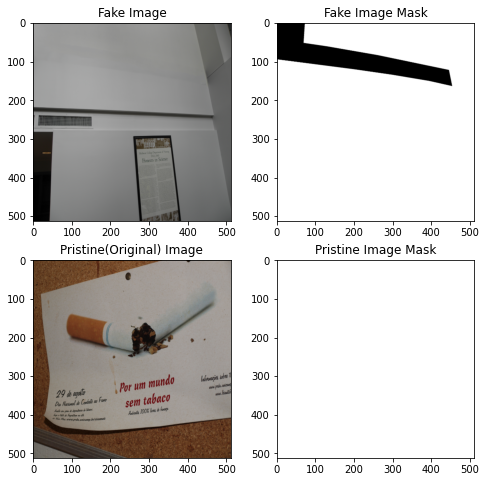

In [9]:
x = 449
y = 242
f,axis = plt.subplots(2,2,figsize=(8,8))
axis[0,0].imshow(x_data[x])
axis[0,0].title.set_text("Fake Image")
axis[0,1].imshow(y_data[x])
axis[0,1].title.set_text("Fake Image Mask")
axis[1,0].imshow(x_data[y])
axis[1,0].title.set_text("Pristine(Original) Image")
axis[1,1].imshow(y_data[y])
axis[1,1].title.set_text("Pristine Image Mask")
plt.show()

## **TRAIN-TEST SPLIT**

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,train_size=0.90,shuffle=True,random_state=10)
print("X-TRAIN SHAPE::",x_train.shape)
print("\nY-TRAIN SHAPE::",y_train.shape)
print("\nX-TEST SHAPE::",x_test.shape)
print("\nY-TEST SHAPE::",y_test.shape)

X-TRAIN SHAPE:: (450, 512, 512, 3)

Y-TRAIN SHAPE:: (450, 512, 512, 3)

X-TEST SHAPE:: (50, 512, 512, 3)

Y-TEST SHAPE:: (50, 512, 512, 3)


In [0]:
x_test = np.load("/content/drive/My Drive/DL_PROJECT/PROJECT/x_test.npy")
y_test = np.load("/content/drive/My Drive/DL_PROJECT/PROJECT/y_test.npy")

In [5]:
x_test.shape,y_test.shape

((50, 512, 512, 3), (50, 512, 512, 3))

# **PERFORMING DATA AUGMENTATION AND SAVING IMAGES INTO DRIVE**

In [0]:
def horizontalFlip(image,mask):
    aug = HorizontalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_hflip = augmented['image']
    mask_hflip = augmented['mask']
    return image_hflip,mask_hflip

def verticalFlip(image,mask):
    aug = VerticalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_vflip = augmented['image']
    mask_vflip = augmented['mask']
    return image_vflip,mask_vflip

In [12]:
path="/content/drive/My Drive/DL_PROJECT/PROJECT/aug_images_masks/"
for i in tqdm(range(len(x_train)),leave=True,position=0): ## total of 15 transformations applied..
    
    matplotlib.image.imsave(path+str(i)+"_"+"orig.png",x_train[i])
    matplotlib.image.imsave(path+str(i)+"_"+"orig"+"_"+"mask.png",y_train[i])
    
    aug = horizontalFlip(x_train[i],y_train[i])
    matplotlib.image.imsave(path+str(i)+"_"+"hflip.png",aug[0])
    matplotlib.image.imsave(path+str(i)+"_"+"hflip"+"_"+"mask.png",aug[1])

    aug = verticalFlip(x_train[i],y_train[i])
    matplotlib.image.imsave(path+str(i)+"_"+"vflip.png",aug[0])
    matplotlib.image.imsave(path+str(i)+"_"+"vflip"+"_"+"mask.png",aug[1])

100%|██████████| 450/450 [05:23<00:00,  1.39it/s]


# **VISUALIZATION OF IMAGES AND CORRESPONDING MASKS AFTER DATA AUGMENTATION**

*   Due to Spacial Constraints only two augmentations were performed


*   I strongly recommend to perform more number of augmentations if surplus amount of RAM is available with you.






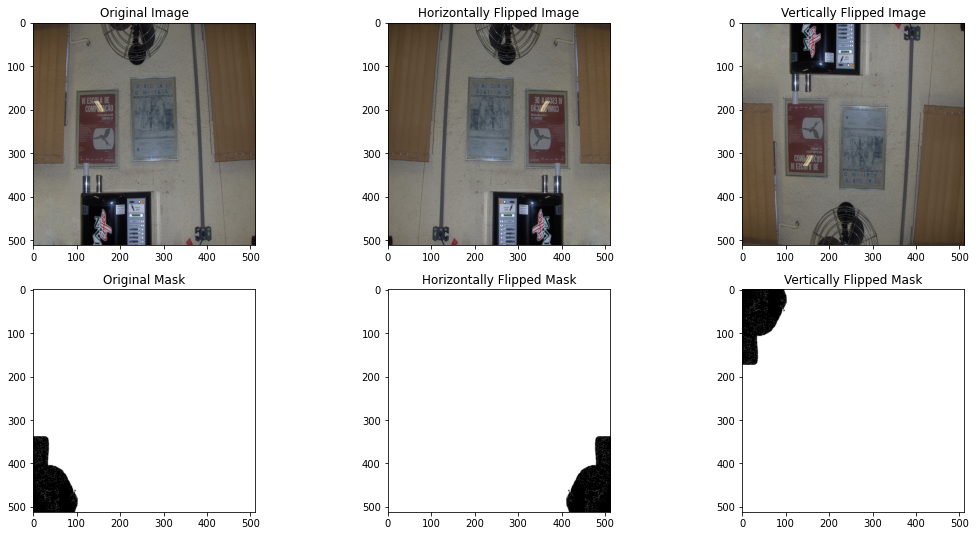

In [0]:
k=45
f, axarr = plt.subplots(2,3,figsize=(18,9))

axarr[0,0].imshow(x_train_aug[k])
axarr[0,0].title.set_text("Original Image")
axarr[0,1].imshow(x_train_aug[k+1])
axarr[0,1].title.set_text("Horizontally Flipped Image")
axarr[0,2].imshow(x_train_aug[k+2])
axarr[0,2].title.set_text("Vertically Flipped Image")

axarr[1,0].imshow(y_train_aug[k])
axarr[1,0].title.set_text("Original Mask")
axarr[1,1].imshow(y_train_aug[k+1])
axarr[1,1].title.set_text("Horizontally Flipped Mask")
axarr[1,2].imshow(y_train_aug[k+2])
axarr[1,2].title.set_text("Vertically Flipped Mask")
plt.show()

# **READING THE DATA AUGMENTED IMAGES**

In [13]:
path="/content/drive/My Drive/DL_PROJECT/PROJECT/aug_images_masks"
count_images = next(os.walk(path+"/"))[2] # list of names all images in the given path
print("Count of Augmented Images(images+masks)::", len(count_images))

Count of Augmented Images(images+masks):: 2700


In [0]:
def read_aug(path):
  x_train_aug = np.zeros((1350,512,512,3), dtype=np.float32)
  y_train_aug = np.zeros((1350,512,512,3), dtype=np.float32)
  count=0
  for im in tqdm(glob.glob(path+'/*.*'),leave=True,position=0):
    head,tail = os.path.split(im)
    if "mask" not in tail:
      l = tail.split(".")
      im = load_img(im)
      mask = load_img(path+"/"+l[0]+"_mask"+".png")
      x_train_aug[count] = im
      y_train_aug[count] = mask
      count=count+1
  print("\n"+str(count)+" IMAGES READ..")
  x_train_aug = x_train_aug/255
  y_train_aug = y_train_aug/255
  return x_train_aug,y_train_aug

In [15]:
path="/content/drive/My Drive/DL_PROJECT/PROJECT/aug_images_masks"
x_train_aug,y_train_aug = read_aug(path)
print("\nSHAPE OF X-TRAIN AFTER DATA AUGMENTATION::",x_train_aug.shape)
print("\nSHAPE OF Y-TRAIN AFTER DATA AUGMENTATION::",y_train_aug.shape)

100%|██████████| 2700/2700 [00:28<00:00, 94.81it/s]



1350 IMAGES READ..

SHAPE OF X-TRAIN AFTER DATA AUGMENTATION:: (1350, 512, 512, 3)

SHAPE OF Y-TRAIN AFTER DATA AUGMENTATION:: (1350, 512, 512, 3)


## **SAVING AUGMENTED IMAGES & MASKS**

In [0]:
'''np.save("/content/drive/My Drive/DL_PROJECT/PROJECT/x_train_aug.npy",x_train_aug)'''

In [0]:
'''np.save("/content/drive/My Drive/DL_PROJECT/PROJECT/y_train_aug.npy",y_train_aug)'''

## **LOADING AUGMENTED MASKS**

In [0]:
x_train_aug = np.load("/content/drive/My Drive/DL_PROJECT/PROJECT/x_train_aug.npy")

In [0]:
y_train_aug = np.load("/content/drive/My Drive/DL_PROJECT/PROJECT/y_train_aug.npy")

In [7]:
y_train_aug.shape

(1350, 512, 512, 3)

## **PERFORMING ELA (ERROR LEVEL ANALYSIS) ON TRAINING DATA**

In [0]:
#ref:https://gist.github.com/ewencp/3356622
def ELA(i,im):
  path1="/content/drive/My Drive/DL_PROJECT/PROJECT/fake_aug_less_quality"
  resaved = str(i)+'.resaved.jpg'
  ela = str(i)+'.ela.png'
  ## read numpy array as image
  im.save(path1+"/"+resaved,'JPEG',quality=95) ## saving image with low quality
  resaved_im = Image.open(path1+"/"+resaved) ## opening low quality image
  ela_im = ImageChops.difference(im,resaved_im) ## difference bw low and high quality images
  extrema = ela_im.getextrema()
  max_diff = max([ex[1] for ex in extrema])
  #print("max_diff:",max_diff)
  try:
    scale = 255.0/max_diff
  except:
    scale = 255.0
  ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
  return ela_im

In [0]:
def read_aug(path):
  x_train_aug_ela = np.zeros((1350,512,512,3), dtype=np.float32)
  count=0
  for im in tqdm(glob.glob(path+'/*.*'),leave=True,position=0):
    head,tail = os.path.split(im)
    if "mask" not in tail:
      l = tail.split(".")
      img = load_img(im)
      im_ela = ELA(count,img)  ## call to ELA
      mask = load_img(path+"/"+l[0]+"_mask"+".png")
      x_train_aug_ela[count] = im_ela
      count=count+1
  print("\n"+str(count)+" IMAGES READ..")
  x_train_aug_ela = x_train_aug_ela/255
  return x_train_aug_ela

In [10]:
path="/content/drive/My Drive/DL_PROJECT/PROJECT/aug_images_masks"
x_train_aug_ela = read_aug(path)
print("Done Performing ELA on Augmented Images...!")

100%|██████████| 2700/2700 [04:02<00:00, 11.14it/s]



1350 IMAGES READ..
Done Performing ELA on Augmented Images...!


## **SAVING THE AUGMENTED & ELA PERFORMED DATA**

In [0]:
'''np.save("/content/drive/My Drive/DL_PROJECT/PROJECT/x_train_aug_ela.npy",x_train_aug_ela)'''

## **LOADING THE AUGMENTED & ELA PERFORMED DATA**

In [0]:
x_train_aug_ela = np.load("/content/drive/My Drive/DL_PROJECT/PROJECT/x_train_aug_ela.npy")

## **PERFORMING ELA (ERROR LEVEL ANALYSIS) ON TEST DATA**

In [0]:
#ref:https://gist.github.com/ewencp/3356622
def ELA_test(i,im):
  path1="/content/drive/My Drive/DL_PROJECT/PROJECT/fake_aug_less_quality_test"
  resaved = str(i)+'.resaved.jpg'
  ela = str(i)+'.ela.png'
  ## read numpy array as image
  im.save(path1+"/"+resaved,'JPEG',quality=95) ## saving image with low quality
  resaved_im = Image.open(path1+"/"+resaved) ## opening low quality image
  ela_im = ImageChops.difference(im,resaved_im) ## difference bw low and high quality images
  extrema = ela_im.getextrema()
  max_diff = max([ex[1] for ex in extrema])
  #print("max_diff:",max_diff)
  try:
    scale = 255.0/max_diff
  except:
    scale = 255.0
  ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
  return ela_im

In [13]:
x_test_ela = np.zeros((50,512,512,3), dtype=np.float32)
path_test = "/content/drive/My Drive/DL_PROJECT/PROJECT/test_images/"
for i in tqdm(range(len(x_test)),leave=True,position=0):
  matplotlib.image.imsave(path_test+str(i)+"_"+"test.png",x_test[i])
  img = load_img(path_test+str(i)+"_"+"test.png")
  im_ela = ELA_test(i,img)  ## call to ELA
  x_test_ela[i]=im_ela
x_test_ela = x_test_ela/255
print("\n\nDone Performing ELA on Test Images...!")

100%|██████████| 50/50 [00:13<00:00,  3.84it/s]



Done Performing ELA on Test Images...!


## **VISUALIZATION OF AN IMAGE SAMPLE IN THE DATA AFTER PERFORMING ELA (IDEAL CASE)**


*   The Same might not happen with every image in data. The below shown image is best case outcome of ELA



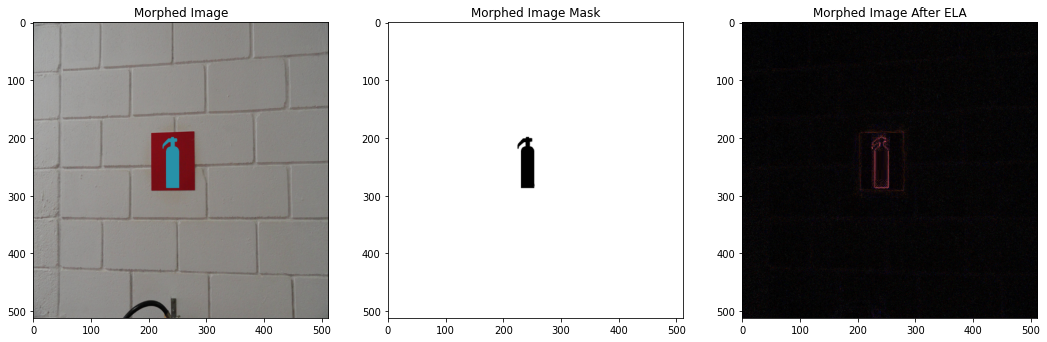

In [62]:
f, axarr = plt.subplots(1,3,figsize=(18,18))

axarr[0].imshow(x_test[5])
axarr[0].title.set_text("Morphed Image")

axarr[1].imshow(y_test[5])
axarr[1].title.set_text("Morphed Image Mask")

axarr[2].imshow(x_test_ela[5])
axarr[2].title.set_text("Morphed Image After ELA")
plt.show()

# **DEFINING THE IoU METRIC FOR PERFORMANCE EVALUATION** 

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  return ((intersection + smooth) / ( union + smooth))

# **CODE TO LOAD IMAGES BATCH WISE**

In [0]:
def LoadImages(batch):
    return np.array([resize(file_name, (512,512,3))for file_name in batch])

def loadImagesBatchwise(X_train,y_train, batch_size):
    train_image_files=X_train
    train_mask_files=y_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            Y = LoadImages(train_mask_files[batch_start:limit])
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size

# **U-NET WITH PRE-TRAINED WEIGHTS FROM RESNET101**

In [34]:
unet_resnet101 = Unet('resnet101', input_shape=(512,512,3), classes=3, activation='sigmoid',encoder_weights='imagenet')
unet_resnet101.compile(optimizer=keras.optimizers.Adam(0.0001), loss="binary_crossentropy", metrics=[iou_coef])
batch_size=3
unet_resnet101_values=unet_resnet101.fit_generator(loadImagesBatchwise(x_train_aug_ela,y_train_aug,batch_size),steps_per_epoch=(len(x_train_aug_ela)//batch_size),epochs=10,validation_data=loadImagesBatchwise(x_test_ela,y_test,batch_size),validation_steps=len(x_test_ela)//batch_size)

Epoch 1/10
450/450 [==============================] - 237s 526ms/step - loss: 0.3721 - iou_coef: 0.7853 - val_loss: 0.4666 - val_iou_coef: 0.8481
Epoch 2/10
450/450 [==============================] - 191s 425ms/step - loss: 0.2373 - iou_coef: 0.8872 - val_loss: 0.2781 - val_iou_coef: 0.8914
Epoch 3/10
450/450 [==============================] - 191s 423ms/step - loss: 0.2270 - iou_coef: 0.9057 - val_loss: 1.2707 - val_iou_coef: 0.9389
Epoch 4/10
450/450 [==============================] - 190s 423ms/step - loss: 0.2261 - iou_coef: 0.9107 - val_loss: 1.9614 - val_iou_coef: 0.9202
Epoch 5/10
450/450 [==============================] - 190s 422ms/step - loss: 0.2259 - iou_coef: 0.9118 - val_loss: 0.1958 - val_iou_coef: 0.9179
Epoch 6/10
450/450 [==============================] - 190s 423ms/step - loss: 0.2241 - iou_coef: 0.9120 - val_loss: 0.0873 - val_iou_coef: 0.9182
Epoch 7/10
450/450 [==============================] - 191s 424ms/step - loss: 0.2201 - iou_coef: 0.9126 - val_loss: 1.5776 -

In [0]:
'''unet_resnet101.save("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/resnet101_unet_phase_2.h5") '''

## **PREDICTIONS ON TEST DATA**

In [0]:
pred = unet_resnet101.predict(x_test_ela)

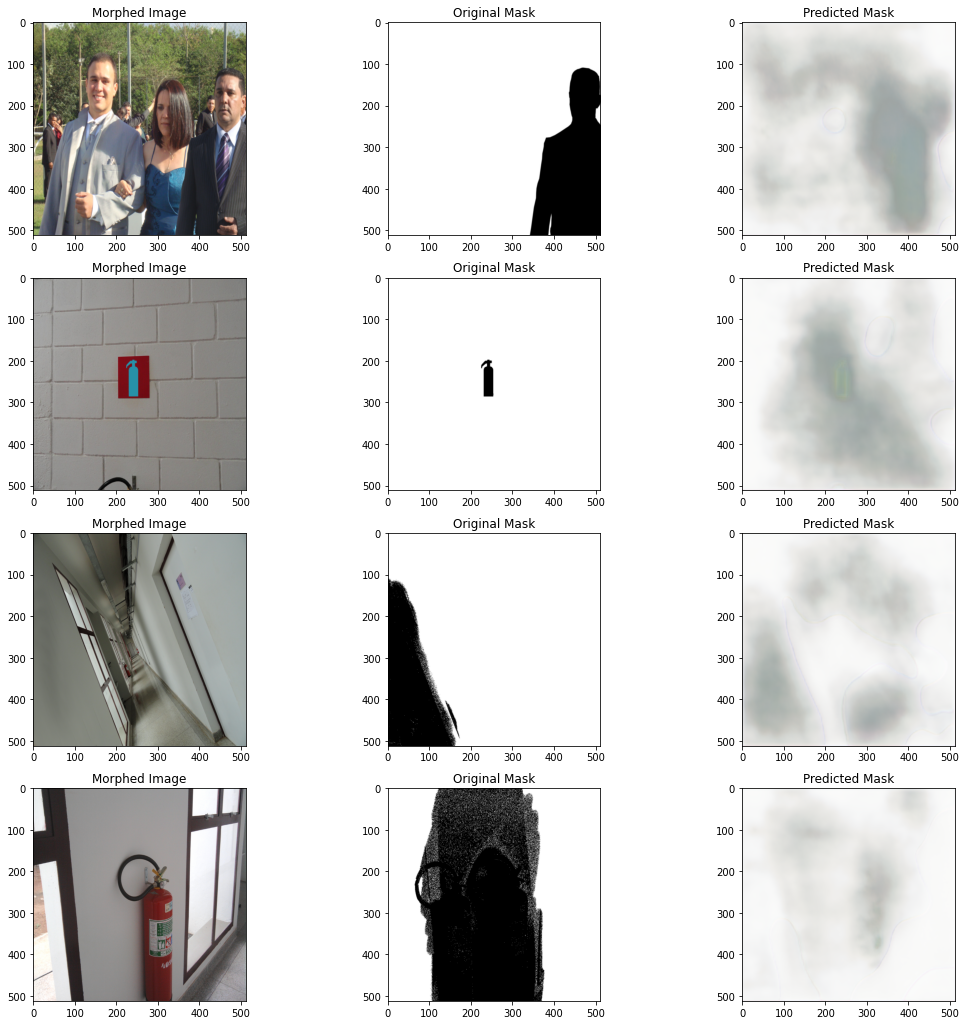

In [54]:
f, axarr = plt.subplots(4,3,figsize=(18,18))

axarr[0,0].imshow(x_test[8])
axarr[0,0].title.set_text("Morphed Image")
axarr[0,1].imshow(y_test[8])
axarr[0,1].title.set_text("Original Mask")
axarr[0,2].imshow(pred[8])
axarr[0,2].title.set_text("Predicted Mask")

axarr[1,0].imshow(x_test[5])
axarr[1,0].title.set_text("Morphed Image")
axarr[1,1].imshow(y_test[5])
axarr[1,1].title.set_text("Original Mask")
axarr[1,2].imshow(pred[5])
axarr[1,2].title.set_text("Predicted Mask")

axarr[2,0].imshow(x_test[10])
axarr[2,0].title.set_text("Morphed Image")
axarr[2,1].imshow(y_test[10])
axarr[2,1].title.set_text("Original Mask")
axarr[2,2].imshow(pred[10])
axarr[2,2].title.set_text("Predicted Mask")

axarr[3,0].imshow(x_test[47])
axarr[3,0].title.set_text("Morphed Image")
axarr[3,1].imshow(y_test[47])
axarr[3,1].title.set_text("Original Mask")
axarr[3,2].imshow(pred[47])
axarr[3,2].title.set_text("Predicted Mask")

plt.show()

In [0]:
import shutil
shutil.rmtree('/content/drive/My Drive/DL_PROJECT/PROJECT/aug_images_masks')
shutil.rmtree('/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/aug_images_masks')